# Installing Necessary Libraries#


In [1]:
# We need to install several libraries that are essential for our Named Entity Recognition (NER) task using BERT.
# These libraries include transformers, evaluate, datasets, tokenizers, seqeval, torch, tf-keras.

%pip install transformers -q
%pip install evaluate -q
%pip install datasets -q
%pip install tokenizers -q
%pip install seqeval -q
%pip install torch -q
%pip install tf-keras -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Import Required Libraries

In [2]:
# Import Required Libraries
from transformers import BertTokenizerFast, BertForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from datasets import load_dataset
from evaluate import load as load_metric
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset and Metric


In [3]:
# Load Dataset and Metric

# We will load the CoNLL-2003 dataset, which is commonly used for Named Entity Recognition (NER) tasks.
# Additionally, we will load the seqeval metric, which is used for evaluating sequence labeling tasks.


dataset = load_dataset('conll2003',trust_remote_code=True)

# Load the seqeval metric using the load function from the evaluate library.
metric = load_metric('seqeval')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [4]:
dataset.shape
dataset["train"].features["ner_tags"]

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

# Define Activation Functions

In [5]:
# Here we define custom activation functions that will be used in our model.
# Activation functions introduce non-linearity into the model, allowing it to learn complex patterns.
def hyperbolic_tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Preprocessing Function


In [6]:
# Define a function to tokenize the input text and align the labels with the tokens.
# This function will be used to preprocess the dataset before feeding it into the model.

# The function takes a batch of examples as input and returns tokenized inputs with aligned labels.
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True, padding='max_length', max_length=128)
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_id = None
        for word_id in word_ids:
            # If the word ID is None, it means the token is a special token (e.g., [CLS], [SEP], [PAD]).
            # In this case, we append -100 to the label IDs to ignore the token during training.
            if word_id is None:
                label_ids.append(-100)
            # If the word ID is different from the previous word ID, it means the token is the first token of a new word.
            # In this case, we append the label of the current word to the label IDs.
            elif word_id != previous_word_id:
                label_ids.append(label[word_id])
            # If the word ID is the same as the previous word ID, it means the token is a subword of the previous word.
            # In this case, we append -100 to the label IDs to ignore the token during training.
            else:
                label_ids.append(-100)
            previous_word_id = word_id
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels

    return tokenized_inputs

# Load Pre-trained Tokenizer
The first application we’ll explore is token classification. This generic task encompasses any problem that can be formulated as “attributing a label to each token in a sentence,” such as:

**Named entity recognition (NER):** Find the entities (such as persons, locations, or organizations) in a sentence. This can be formulated as attributing a label to each token by having one class per entity and one class for “no entity.”

**Part-of-speech tagging (POS):** Mark each word in a sentence as corresponding to a particular part of speech (such as noun, verb, adjective, etc.).

**Chunking:** Find the tokens that belong to the same entity. This task (which can be combined with POS or NER) can be formulated as attributing one label (usually B-) to any tokens that are at the beginning of a chunk, another label (usually I-) to tokens that are inside a chunk, and a third label (usually O) to tokens that don’t belong to any chunk.

* O means the word doesn’t correspond to any entity.
* B-PER/I-PER means the word corresponds to the beginning of/is inside a person entity.
* B-ORG/I-ORG means the word corresponds to the beginning of/is inside an organization entity.
* B-LOC/I-LOC means the word corresponds to the beginning of/is inside a location entity.
* B-MISC/I-MISC means the word corresponds to the beginning of/is inside a miscellaneous entity.

In [7]:
# Load Pre-trained Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

# Tokenize Dataset


In [8]:
# Tokenize Dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

# Load Pre-trained Model


In [9]:
# Load Pre-trained Model
model = BertForTokenClassification.from_pretrained(
    'bert-large-uncased',
    num_labels=len(dataset['train'].features['ner_tags'].feature.names)
)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Data Collator

In [10]:
# Data Collator
# The data collator will handle padding and batching of the tokenized inputs and labels.
# The data collator will ensure that the input sequences are padded to the same length and batched together.
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Compute Metrics with Activation Function



In [11]:
# Compute Metrics with Activation Function
label_list = dataset['train'].features['ner_tags'].feature.names

def compute_metrics_with_activation(predictions, activation_func):
    predictions, labels = predictions
    activated_predictions = activation_func(predictions)  # Apply activation function to logits
    probabilities = F.softmax(torch.tensor(activated_predictions), dim=2).numpy()
    predicted_labels = np.argmax(probabilities, axis=2)

  # Convert the true labels to their corresponding label names, ignoring padding tokens (-100).
    true_labels = [[label_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predicted_labels, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        'precision': results['overall_precision'],
        'recall': results['overall_recall'],
        'f1': results['overall_f1'],
        'accuracy': results['overall_accuracy'],
    }

# Training Arguments


In [12]:
# Training Arguments
# The TrainingArguments class from the transformers library allows us to specify various training parameters.
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.1,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=100,
    save_strategy='epoch',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Trainer Initialization


In [13]:
# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda p: compute_metrics_with_activation(p, hyperbolic_tanh),
)

<ipython-input-13-02cb42b12d32>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Train the Model


In [14]:
# Train the Model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.059600,0.050707,0.930047,0.940226,0.935108,0.987769
2,0.030800,0.047990,0.943824,0.953359,0.948568,0.989541
3,0.009900,0.048627,0.946348,0.953359,0.949841,0.989560


TrainOutput(global_step=2634, training_loss=0.05226382252250373, metrics={'train_runtime': 3634.7573, 'train_samples_per_second': 11.589, 'train_steps_per_second': 0.725, 'total_flos': 9780213271931136.0, 'train_loss': 0.05226382252250373, 'epoch': 3.0})

# Evaluate the Model


In [15]:
# Evaluate the Model on Test dataset
eval_results = trainer.evaluate(tokenized_datasets['test'])
print('Evaluation results:', eval_results)

Evaluation results: {'eval_loss': 0.12686918675899506, 'eval_precision': 0.9042366946778712, 'eval_recall': 0.9148069429684732, 'eval_f1': 0.9094911075893642, 'eval_accuracy': 0.9814539579967689, 'eval_runtime': 80.7967, 'eval_samples_per_second': 42.737, 'eval_steps_per_second': 2.673, 'epoch': 3.0}


# Save the Model


In [16]:
# Save the Model
trainer.save_model('./ner_bert_model')
tokenizer.save_pretrained('./ner_bert_model')

('./ner_bert_model/tokenizer_config.json',
 './ner_bert_model/special_tokens_map.json',
 './ner_bert_model/vocab.txt',
 './ner_bert_model/added_tokens.json',
 './ner_bert_model/tokenizer.json')

# Confusion Matrix

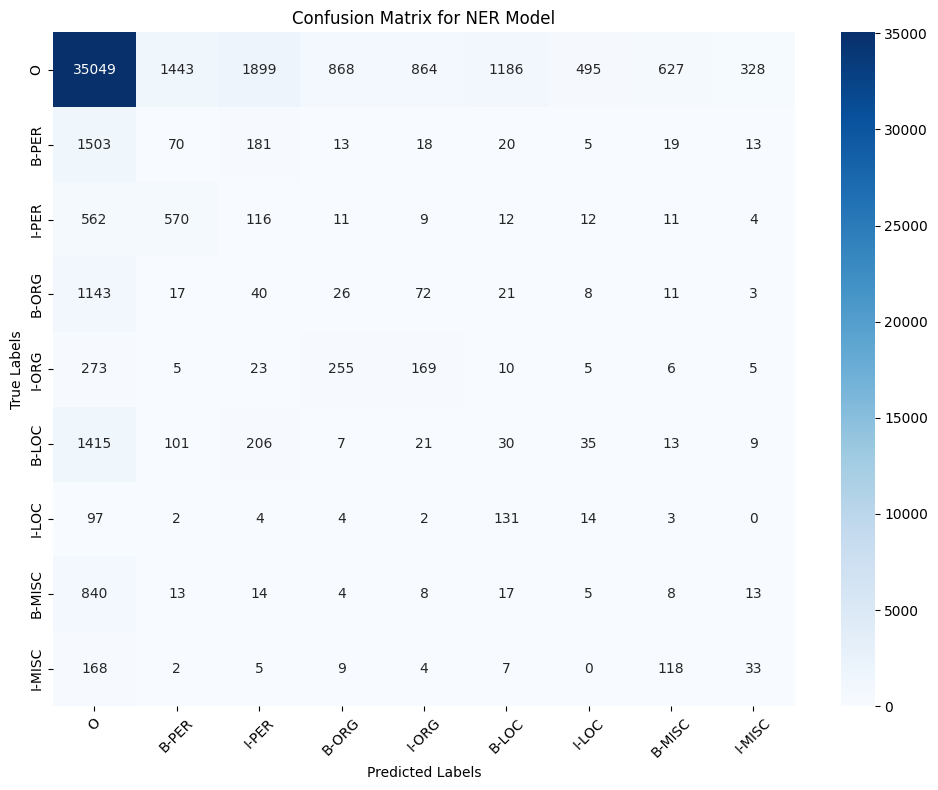

In [17]:
# Function to get predictions and labels
# In this section, we will generate and display a confusion matrix for the model's predictions.
# The confusion matrix will help us understand the performance of the model by showing the true and predicted labels.

def get_predictions_and_labels(trainer, eval_dataset):
    raw_pred, _, _ = trainer.predict(eval_dataset)
    predictions = np.argmax(raw_pred, axis=2)

    # Flatten lists for confusion matrix
    true_labels = eval_dataset["ner_tags"]

    predictions_flat = []
    true_labels_flat = []

    for pred, true in zip(predictions, true_labels):
        for p, t in zip(pred, true):
            if t != -100:  # Ignore padding tokens
                predictions_flat.append(p)
                true_labels_flat.append(t)

    return predictions_flat, true_labels_flat

# Generate predictions and true labels
predictions_flat, true_labels_flat = get_predictions_and_labels(trainer, tokenized_datasets["validation"])

# Generate confusion matrix
cm = confusion_matrix(true_labels_flat, predictions_flat, labels=list(range(len(label_list))))

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.title('Confusion Matrix for NER Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#Error Analysis

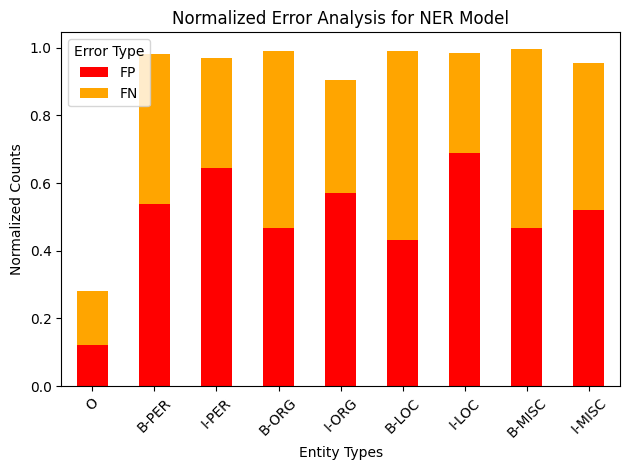

Misclassifications:
Text: West Indian all-rounder Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship .
True: B-ORG, Predicted: O

Text: Their stay on top , though , may be short-lived as title rivals Essex , Derbyshire and Surrey all closed in on victory while Kent made up for lost time in their rain-affected match against Nottinghamshire .
True: O, Predicted: B-ORG

Text: Derbyshire kept up the hunt for their first championship title since 1936 by reducing Worcestershire to 133 for five in their second innings , still 100 runs away from avoiding an innings defeat .
True: B-LOC, Predicted: O

Text: Australian Tom Moody took six for 82 but Chris Adams , 123 , and Tim O'Gorman , 109 , took Derbyshire to 471 and a first innings lead of 233 .
True: O, Predicted: B-LOC

Text: After the frustration of seeing the opening day of their match badly affected by the weather , Kent stepped

In [18]:
# In this section, we will perform error analysis to identify true positives, false positives, and false negatives.
# We will also display misclassifications to understand where the model is making errors.
error_counts = {label: {'TP': 0, 'FP': 0, 'FN': 0} for label in label_list}

for true, pred in zip(true_labels_flat, predictions_flat):
    if true == pred:
        error_counts[label_list[true]]['TP'] += 1
    else:
        error_counts[label_list[true]]['FN'] += 1
        error_counts[label_list[pred]]['FP'] += 1

# Convert error counts to a DataFrame
error_df = pd.DataFrame(error_counts).T

# Normalize errors by entity type
error_df_normalized = error_df.div(error_df.sum(axis=1), axis=0).fillna(0)  # Normalize by row sum

# Plot normalized error analysis
error_df_normalized[['FP', 'FN']].plot(kind='bar', stacked=True, color=['red', 'orange'])
plt.title('Normalized Error Analysis for NER Model')
plt.xlabel('Entity Types')
plt.ylabel('Normalized Counts')
plt.xticks(rotation=45)
plt.legend(title='Error Type')
plt.tight_layout()
plt.show()

# Misclassifications
misclassifications = [
    (label_list[true], label_list[pred], example)
    for true, pred, example in zip(true_labels_flat, predictions_flat, tokenized_datasets["validation"]["tokens"])
    if true != pred
]

print("Misclassifications:")
for true, pred, example in misclassifications[:5]:  # Show first 5 misclassifications
    print(f"Text: {' '.join(example)}\nTrue: {true}, Predicted: {pred}\n")
